In [1]:
!pip install datasets==3.6.0 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 5.7 MB/s eta 0:00:00


In [2]:
import pandas as pd

In [3]:
from datasets import load_dataset_builder, Split
from torch.utils.data import DataLoader
from torch.utils.data.sampler import BatchSampler, RandomSampler, SequentialSampler

# Explicit builder
builder = load_dataset_builder(
    "tobiolatunji/afrispeech-200",
    name="pidgin"
)

# Run dataset script
builder.download_and_prepare()

# Create dataset
pidgin_speech = builder.as_dataset()

train_ds = pidgin_speech[Split.TRAIN]
dev_ds   = pidgin_speech[Split.VALIDATION]
test_ds  = pidgin_speech[Split.TEST]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

afrispeech-200.py: 0.00B [00:00, ?B/s]

accent_stats.py: 0.00B [00:00, ?B/s]

The repository for tobiolatunji/afrispeech-200 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/tobiolatunji/afrispeech-200.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


audio/pidgin/train/train_pidgin_0.tar.gz:   0%|          | 0.00/440M [00:00<?, ?B/s]

audio/pidgin/dev/dev_pidgin_0.tar.gz:   0%|          | 0.00/18.7M [00:00<?, ?B/s]

audio/pidgin/test/test_pidgin_0.tar.gz:   0%|          | 0.00/33.9M [00:00<?, ?B/s]

transcripts/pidgin/train.csv:   0%|          | 0.00/156k [00:00<?, ?B/s]

transcripts/pidgin/dev.csv:   0%|          | 0.00/7.85k [00:00<?, ?B/s]

transcripts/pidgin/test.csv:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]


Reading metadata...: 439it [00:00, 47951.76it/s]


Generating validation split: 0 examples [00:00, ? examples/s]


Reading metadata...: 26it [00:00, 8541.70it/s]


Generating test split: 0 examples [00:00, ? examples/s]


Reading metadata...: 45it [00:00, 32137.52it/s]


In [16]:
len(train_ds), len(dev_ds), len(test_ds)

(439, 26, 45)

In [17]:
from datasets import DatasetDict
import numpy as np
from collections import Counter, defaultdict

In [18]:
def fix_age_group(example):
    age = example.get("age_group")
    if age is None or str(age).strip() == "":
        example["age_group"] = "Unknown"
    return example

train_ds = train_ds.map(fix_age_group)
test_ds  = test_ds.map(fix_age_group)
dev_ds   = dev_ds.map(fix_age_group)

Map:   0%|          | 0/439 [00:00<?, ? examples/s]

KeyboardInterrupt: 

In [19]:
def gender_stats(ds):
    total = len(ds)
    counts = Counter(ds["gender"])

    for k, v in counts.items():
        pct = (v / total) * 100
        print(f"{k}: {v} ({pct:.2f}%)")

In [20]:
gender_stats(train_ds)

Male: 361 (82.23%)
Female: 78 (17.77%)


In [21]:
def age_group_stats(ds):
    total = len(ds)
    counts = Counter(ds["age_group"])

    for k, v in counts.items():
        pct = (v / total) * 100
        print(f"{k}: {v} ({pct:.2f}%)")

In [26]:
age_group_stats(train_ds)

19-25: 231 (52.62%)
26-40: 76 (17.31%)
56yrs>: 44 (10.02%)
41-55: 88 (20.05%)


In [27]:
def domain_stats(ds):
    total = len(ds)
    counts = Counter(ds["domain"])

    for k, v in counts.items():
        pct = (v / total) * 100
        print(f"{k}: {v} ({pct:.2f}%)")

In [28]:
domain_stats(train_ds)

clinical: 204 (46.47%)
general: 235 (53.53%)


In [29]:
def split_statistics(ds):
    speakers = defaultdict(set)
    accents = defaultdict(set)
    speaker_secs = defaultdict(float)
    accent_secs = defaultdict(float)
    domain_counts = Counter()

    for ex in ds:
        spk = ex["speaker_id"]
        acc = ex["accent"]
        dur = len(ex["audio"]["array"]) / ex["audio"]["sampling_rate"]

        speakers[spk].add(ex["speaker_id"])
        accents[acc].add(ex["speaker_id"])
        speaker_secs[spk] += dur
        accent_secs[acc] += dur
        domain_counts[ex["domain"]] += 1

    num_speakers = len(speakers)
    num_accents = len(accents)
    total_secs = sum(speaker_secs.values())

    print(f"# Speakers: {num_speakers}")
    print(f"# Hours: {total_secs / 3600:.2f}")
    print(f"# Accents: {num_accents}")
    print(f"Avg secs/speaker: {np.mean(list(speaker_secs.values())):.2f}")
    print(f"Clips/speaker: {len(ds) / num_speakers:.2f}")
    print(f"Speakers/accent: {num_speakers / num_accents:.2f}")
    print(f"Secs/accent: {np.mean(list(accent_secs.values())):.2f}")
    print(f"# General domain: {domain_counts['general']}")
    print(f"# Clinical domain: {domain_counts['clinical']}")


In [31]:
print("Train split:")
split_statistics(train_ds)

Train split:
# Speakers: 12
# Hours: 1.45
# Accents: 1
Avg secs/speaker: 434.53
Clips/speaker: 36.58
Speakers/accent: 12.00
Secs/accent: 5214.39
# General domain: 235
# Clinical domain: 204


In [32]:
print("Validation split:")
split_statistics(dev_ds)

Validation split:
# Speakers: 2
# Hours: 0.06
# Accents: 1
Avg secs/speaker: 112.32
Clips/speaker: 13.00
Speakers/accent: 2.00
Secs/accent: 224.64
# General domain: 0
# Clinical domain: 26


In [33]:
print("Test split:")
split_statistics(test_ds)

Test split:
# Speakers: 6
# Hours: 0.11
# Accents: 1
Avg secs/speaker: 64.90
Clips/speaker: 7.50
Speakers/accent: 6.00
Secs/accent: 389.37
# General domain: 18
# Clinical domain: 27


In [34]:
def lexical_stats(ds):
    vocab = set()
    durations = []
    word_counts = []

    for ex in ds:
        text = ex["transcript"].split()
        vocab.update(text)
        word_counts.append(len(text))
        durations.append(len(ex["audio"]["array"]) / ex["audio"]["sampling_rate"])

    print(f"Vocabulary size: {len(vocab)}")
    print(f"Avg words/utt: {np.mean(word_counts):.2f}")
    print(f"Avg duration (s): {np.mean(durations):.2f}")

In [35]:
lexical_stats(train_ds)

Vocabulary size: 4122
Avg words/utt: 19.04
Avg duration (s): 11.88


In [36]:
lexical_stats(dev_ds)

Vocabulary size: 228
Avg words/utt: 10.58
Avg duration (s): 8.64


In [37]:
lexical_stats(test_ds)

Vocabulary size: 486
Avg words/utt: 15.60
Avg duration (s): 8.65


In [5]:
train_df = train_ds.to_pandas()
dev_df   = dev_ds.to_pandas()
test_df  = test_ds.to_pandas()

In [6]:
import pandas as pd

pidgin_df = pd.concat([train_df, dev_df, test_df], ignore_index=True)

In [7]:
pidgin_df.head()

,speaker_id,path,audio_id,audio,transcript,age_group,gender,accent,domain,country,duration
0,eea10859e46f925f9e040f8981febbd6,/root/.cache/huggingface/datasets/downloads/ex...,6d3d593b-05e6-4692-bc34-1b19f38a42da/f58c5f8b3...,{'bytes': b'RIFF\xdc\xc3\x17\x00WAVEfmt \x10\x...,Pt had been given ambient at 1am for complaint...,19-25,Male,pidgin,clinical,NG,8.828979
1,77a358578d54492fbc7964f7649879e0,/root/.cache/huggingface/datasets/downloads/ex...,203748b3-b767-4575-8bc6-10c97601a89f/2f846afb5...,{'bytes': b'RIFF0\x86\x18\x00WAVEfmt \x10\x00\...,"For example, immuno blotting analysis will det...",19-25,Male,pidgin,clinical,NG,9.110998
2,6b8b5e193a89f7d1994a56d55ad90c7e,/root/.cache/huggingface/datasets/downloads/ex...,db822b6a-8a98-4771-9cf1-6ca9bc977362/0236ac5cc...,{'bytes': b'RIFFl\x87\t\x00WAVEfmt \x10\x00\x0...,Coronary arteries are extensively calcified.,26-40,Female,pidgin,clinical,NG,3.540000
3,2cccaf777b988e7242fafa0ff3ed7972,/root/.cache/huggingface/datasets/downloads/ex...,867c16a5-20c7-4881-ba19-03e7b967f146/f09cc6805...,{'bytes': b'RIFF\x9c\xe5\x19\x00WAVEfmt \x10\x...,"Kizz has been known for dropping hit songs, so...",56yrs>,Male,pidgin,general,NG,9.620997
4,eea10859e46f925f9e040f8981febbd6,/root/.cache/huggingface/datasets/downloads/ex...,05a6e5ac-79fe-4e20-9fc2-20ad0f39e0d0/eeb55bbb2...,{'bytes': b'RIFF\xe0\x12*\x00WAVEfmt \x10\x00\...,"And, according to The Sun, Prince Harry has al...",19-25,Male,pidgin,general,NG,15.630998


In [8]:
pidgin_df = pidgin_df.drop(columns=["audio"])
pidgin_df.head()

,speaker_id,path,audio_id,transcript,age_group,gender,accent,domain,country,duration
0,eea10859e46f925f9e040f8981febbd6,/root/.cache/huggingface/datasets/downloads/ex...,6d3d593b-05e6-4692-bc34-1b19f38a42da/f58c5f8b3...,Pt had been given ambient at 1am for complaint...,19-25,Male,pidgin,clinical,NG,8.828979
1,77a358578d54492fbc7964f7649879e0,/root/.cache/huggingface/datasets/downloads/ex...,203748b3-b767-4575-8bc6-10c97601a89f/2f846afb5...,"For example, immuno blotting analysis will det...",19-25,Male,pidgin,clinical,NG,9.110998
2,6b8b5e193a89f7d1994a56d55ad90c7e,/root/.cache/huggingface/datasets/downloads/ex...,db822b6a-8a98-4771-9cf1-6ca9bc977362/0236ac5cc...,Coronary arteries are extensively calcified.,26-40,Female,pidgin,clinical,NG,3.540000
3,2cccaf777b988e7242fafa0ff3ed7972,/root/.cache/huggingface/datasets/downloads/ex...,867c16a5-20c7-4881-ba19-03e7b967f146/f09cc6805...,"Kizz has been known for dropping hit songs, so...",56yrs>,Male,pidgin,general,NG,9.620997
4,eea10859e46f925f9e040f8981febbd6,/root/.cache/huggingface/datasets/downloads/ex...,05a6e5ac-79fe-4e20-9fc2-20ad0f39e0d0/eeb55bbb2...,"And, according to The Sun, Prince Harry has al...",19-25,Male,pidgin,general,NG,15.630998


In [9]:
pidgin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510 entries, 0 to 509
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   speaker_id  510 non-null    object 
 1   path        510 non-null    object 
 2   audio_id    510 non-null    object 
 3   transcript  510 non-null    object 
 4   age_group   510 non-null    object 
 5   gender      510 non-null    object 
 6   accent      510 non-null    object 
 7   domain      510 non-null    object 
 8   country     510 non-null    object 
 9   duration    510 non-null    float32
dtypes: float32(1), object(9)
memory usage: 38.0+ KB


In [10]:
num_samples = len(pidgin_df)
num_speakers = pidgin_df["speaker_id"].nunique()

num_samples, num_speakers

(510, 20)

In [11]:
pidgin_df["duration"].describe()

,duration
count,510.000000
mean,11.428247
std,6.711562
min,1.264989
25%,6.022239
50%,9.992494
75%,15.584484
max,36.212994


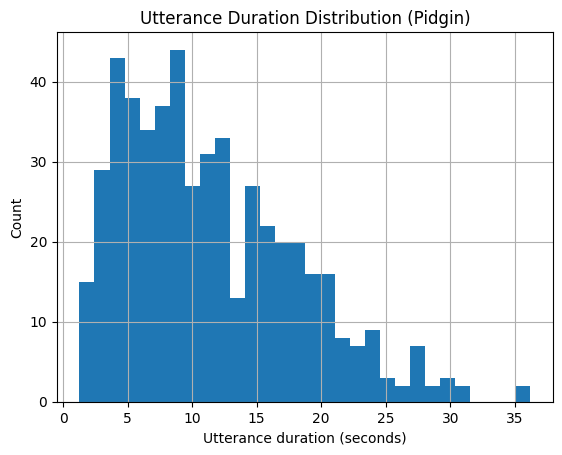

In [12]:
import matplotlib.pyplot as plt

pidgin_df["duration"].hist(bins=30)
plt.xlabel("Utterance duration (seconds)")
plt.ylabel("Count")
plt.title("Utterance Duration Distribution (Pidgin)")
plt.show()

In [13]:
pidgin_df["num_words"] = pidgin_df["transcript"].str.split().apply(len)
pidgin_df["num_chars"] = pidgin_df["transcript"].str.len()

pidgin_df[["num_words", "num_chars"]].describe()

,num_words,num_chars
count,510.000000,510.000000
mean,18.303922,113.347059
std,10.000579,58.773475
min,1.000000,13.000000
25%,10.250000,66.000000
50%,17.500000,107.000000
75%,25.000000,157.000000
max,55.000000,250.000000


In [14]:
from collections import Counter

all_words = " ".join(pidgin_df["transcript"]).lower().split()
vocab = Counter(all_words)

len(vocab), vocab.most_common(20)

(4227,
 [('the', 411),
  ('of', 265),
  ('and', 257),
  ('to', 200),
  ('in', 175),
  ('a', 160),
  ('for', 107),
  ('is', 107),
  ('with', 95),
  ('on', 81),
  ('at', 55),
  ('was', 55),
  ('as', 53),
  ('are', 52),
  ('that', 51),
  ('by', 46),
  ('it', 45),
  ('this', 41),
  ('or', 40),
  ('be', 38)])

In [15]:
pidgin_df["speaker_id"].value_counts().head(10)

,count
speaker_id,
77a358578d54492fbc7964f7649879e0,167
2cccaf777b988e7242fafa0ff3ed7972,44
eea10859e46f925f9e040f8981febbd6,41
6b8b5e193a89f7d1994a56d55ad90c7e,36
b435436850c3082584c1e8610ef3aef7,32
592bdf3913f6599d07f645174d2a6091,31
6335d845d6c03c8aac3ca204d691b2cc,25
0d2abf2472398ef963e90c8a3b4cb136,19
4e842dd39eb8b265db039caff6838eb8,16


In [16]:
pidgin_df["gender"].value_counts(normalize=True) * 100

,proportion
gender,
Male,80.588235
Female,19.411765


In [17]:
pidgin_df["age_group"].value_counts(normalize=True) * 100

,proportion
age_group,
19-25,51.764706
26-40,18.039216
41-55,17.843137
56yrs>,8.627451
,1.960784
<18yrs,1.764706


In [18]:
pidgin_df["accent"].value_counts(normalize=True) * 100

,proportion
accent,
pidgin,100.0


In [19]:
pidgin_df["country"].value_counts(normalize=True) * 100

,proportion
country,
NG,100.0


In [20]:
pidgin_df["domain"].value_counts(normalize=True) * 100

,proportion
domain,
clinical,50.392157
general,49.607843


In [21]:
english_markers = {
    "the", "is", "are", "was", "were",
    "doctor", "hospital", "medicine", "pain"
}

def is_code_switched(text):
    words = set(text.lower().split())
    return len(words & english_markers) > 0

pidgin_df["code_switched"] = pidgin_df["transcript"].apply(is_code_switched)

pidgin_df["code_switched"].value_counts(normalize=True) * 100

,proportion
code_switched,
True,59.607843
False,40.392157


In [22]:
pidgin_df.groupby("domain")["duration"].mean()

,duration
domain,
clinical,9.813951
general,13.068069


In [23]:
pidgin_df.groupby("accent")["duration"].mean().sort_values(ascending=False)

,duration
accent,
pidgin,11.428248


In [24]:
pidgin_df.groupby("gender")["num_words"].mean()

,num_words
gender,
Female,14.020202
Male,19.335766


In [25]:
summary = {
    "Samples": len(pidgin_df),
    "Speakers": pidgin_df["speaker_id"].nunique(),
    "Avg duration (s)": round(pidgin_df["duration"].mean(), 2),
    "Avg words / utt": round(pidgin_df["num_words"].mean(), 2),
    "Vocabulary size": len(vocab),
    "Code-switched (%)": round(
        pidgin_df["code_switched"].mean() * 100, 1
    )
}

summary = pd.DataFrame(summary, index=[0])
summary

,Samples,Speakers,Avg duration (s),Avg words / utt,Vocabulary size,Code-switched (%)
0,510,20,11.43,18.3,4227,59.6


In [28]:
pidgin_df["domain"]

,domain
0,clinical
1,clinical
2,clinical
3,general
4,general
...,...
505,clinical
506,clinical
507,general
508,clinical


In [29]:
clinical_df = pidgin_df[pidgin_df["domain"] == "clinical"].copy()

print(f"Clinical samples: {len(clinical_df)}")

Clinical samples: 257


In [30]:
clinical_df.head()

,speaker_id,path,audio_id,transcript,age_group,gender,accent,domain,country,duration,num_words,num_chars,code_switched
0,eea10859e46f925f9e040f8981febbd6,/root/.cache/huggingface/datasets/downloads/ex...,6d3d593b-05e6-4692-bc34-1b19f38a42da/f58c5f8b3...,Pt had been given ambient at 1am for complaint...,19-25,Male,pidgin,clinical,NG,8.828979,14,73,False
1,77a358578d54492fbc7964f7649879e0,/root/.cache/huggingface/datasets/downloads/ex...,203748b3-b767-4575-8bc6-10c97601a89f/2f846afb5...,"For example, immuno blotting analysis will det...",19-25,Male,pidgin,clinical,NG,9.110998,25,160,True
2,6b8b5e193a89f7d1994a56d55ad90c7e,/root/.cache/huggingface/datasets/downloads/ex...,db822b6a-8a98-4771-9cf1-6ca9bc977362/0236ac5cc...,Coronary arteries are extensively calcified.,26-40,Female,pidgin,clinical,NG,3.540000,5,44,True
6,77a358578d54492fbc7964f7649879e0,/root/.cache/huggingface/datasets/downloads/ex...,e8387cb0-3213-4dd2-83f4-58f398702048/451565a0b...,Inflammation has been implicated in the role o...,19-25,Male,pidgin,clinical,NG,8.735987,15,101,True
7,77a358578d54492fbc7964f7649879e0,/root/.cache/huggingface/datasets/downloads/ex...,f6ff7b32-9d09-408d-8a60-412ed9f58d84/1b9f939e9...,"They are treated with conservative surgery, si...",19-25,Male,pidgin,clinical,NG,4.560000,14,87,True


In [49]:
general_df = pidgin_df[pidgin_df["domain"] == "general"].copy()

print(f"General samples: {len(general_df)}")

General samples: 253


In [50]:
import re

def normalize(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

clinical_df["normalized"] = clinical_df["transcript"].apply(normalize)
general_df["normalized"]  = general_df["transcript"].apply(normalize)

In [33]:
from collections import Counter

word_counter = Counter()

for text in clinical_df["normalized"]:
    tokens = text.split()
    word_counter.update(tokens)

In [34]:
word_counter.most_common(20)

[('the', 125),
 ('of', 115),
 ('and', 102),
 ('to', 71),
 ('a', 65),
 ('in', 63),
 ('is', 47),
 ('with', 41),
 ('for', 38),
 ('or', 29),
 ('are', 25),
 ('be', 21),
 ('by', 20),
 ('as', 20),
 ('may', 19),
 ('an', 18),
 ('on', 18),
 ('at', 17),
 ('oral', 16),
 ('s', 14)]

In [35]:
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")

stop_words = set(stopwords.words("english"))
# negations = {"no", "not", "never"}
# stop_words = stop_words - negations

clinical_vocab = {
    word: count
    for word, count in word_counter.items()
    if word not in stop_words and len(word) > 2
}

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [58]:
sorted(clinical_vocab.items(), key=lambda x: x[1], reverse=True)[:100]

[('of', 115),
 ('the', 101),
 ('and', 96),
 ('to', 66),
 ('in', 55),
 ('a', 54),
 ('is', 47),
 ('with', 38),
 ('for', 34),
 ('or', 28),
 ('are', 24),
 ('The', 24),
 ('be', 21),
 ('by', 20),
 ('as', 20),
 ('may', 19),
 ('an', 18),
 ('at', 16),
 ('on', 15),
 ('ORAL', 13),
 ('-', 13),
 ('this', 12),
 ('patients', 12),
 ('HYDROCHLORIDE,', 12),
 ('from', 11),
 ('was', 11),
 ('can', 10),
 ('it', 9),
 ('that', 8),
 ('if', 7),
 ('patient', 7),
 ('not', 7),
 ('but', 7),
 ('been', 6),
 ('presence', 6),
 ('A', 6),
 ('no', 6),
 ('CAPSULE,', 6),
 ('more', 6),
 ('unspecified', 6),
 ('right', 6),
 ('during', 6),
 ('well', 6),
 ('TABLET,', 6),
 ('5', 6),
 ('atrial', 6),
 ('has', 5),
 ('injury', 5),
 ('tumor', 5),
 ('have', 5),
 ('due', 5),
 ('TO', 5),
 ('acute', 5),
 ('disease', 5),
 ('some', 5),
 ('when', 5),
 ('which', 5),
 ('also', 5),
 ('given', 4),
 ('its', 4),
 ('common', 4),
 ('form', 4),
 ('AND', 4),
 ('both', 4),
 ('There', 4),
 ('.', 4),
 ('such', 4),
 ('left', 4),
 ('subsequent', 4),
 ('Uns

In [39]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(
    ngram_range=(2, 2),
    min_df=1
)

X = vectorizer.fit_transform(clinical_df["normalized"])
bigrams = vectorizer.get_feature_names_out()

bigram_counts = dict(zip(bigrams, X.sum(axis=0).A1))

In [40]:
bigram_counts

{'04 am': np.int64(1),
 '083 solution': np.int64(1),
 '10 because': np.int64(1),
 '10 fold': np.int64(1),
 '10 mg': np.int64(1),
 '100 but': np.int64(1),
 '100 ml': np.int64(1),
 '100mg underdosing': np.int64(1),
 '100ml nontraumatic': np.int64(1),
 '10th edition': np.int64(1),
 '113 some': np.int64(1),
 '1149 12': np.int64(1),
 '12 5gm': np.int64(1),
 '13 mar': np.int64(1),
 '13 ug': np.int64(1),
 '130 cc': np.int64(1),
 '14 and': np.int64(1),
 '140 achike': np.int64(1),
 '1430 and': np.int64(1),
 '148 for': np.int64(1),
 '15 tidal': np.int64(1),
 '150 cc': np.int64(1),
 '150 cells': np.int64(1),
 '150 we': np.int64(1),
 '150cck day': np.int64(1),
 '1530 to': np.int64(1),
 '160 after': np.int64(1),
 '160 ms': np.int64(1),
 '17 consecutive': np.int64(1),
 '18 years': np.int64(1),
 '1800 olawuyin': np.int64(1),
 '1978 04': np.int64(1),
 '1980 no': np.int64(1),
 '1am for': np.int64(1),
 '1l fluid': np.int64(1),
 '20 cc': np.int64(1),
 '200 mg': np.int64(1),
 '20mg dislocation': np.int64(

In [51]:
from collections import Counter

def build_vocab(df):
    counter = Counter()
    for text in df["transcript"]:
        counter.update(text.split())
    return counter

clinical_vocab = build_vocab(clinical_df)
general_vocab  = build_vocab(general_df)

In [53]:
general_vocab

Counter({'Kizz': 1,
         'has': 30,
         'been': 18,
         'known': 4,
         'for': 63,
         'dropping': 1,
         'hit': 2,
         'songs,': 1,
         'so': 8,
         'when': 5,
         'he': 21,
         'reached': 3,
         'out': 8,
         'to': 127,
         'you': 20,
         'this': 17,
         'track,': 1,
         'how': 4,
         'much': 2,
         'pressure': 3,
         'did': 2,
         'soak': 1,
         'in?': 1,
         'And,': 1,
         'according': 1,
         'The': 38,
         'Sun,': 1,
         'Prince': 1,
         'Harry': 1,
         'always': 1,
         'star': 2,
         'struck': 1,
         'over': 10,
         'Hollywood': 1,
         'it': 21,
         'wont': 1,
         'have': 20,
         'hard': 3,
         'her': 8,
         'persuade': 1,
         'him,': 2,
         'the': 248,
         'former': 1,
         'member': 1,
         'of': 150,
         'inner': 1,
         'circle': 1,
         'said.': 5,


In [54]:
clinical_salience = {}

for word, c_freq in clinical_vocab.items():
    g_freq = general_vocab.get(word, 0)
    clinical_salience[word] = (c_freq + 1) / (g_freq + 1)

In [55]:
CLINICAL_RATIO_THRESHOLD = 2.0   # tunable

clinical_terms = {
    w: clinical_vocab[w]
    for w, score in clinical_salience.items()
    if score >= CLINICAL_RATIO_THRESHOLD and len(w) > 3
}

In [61]:
sorted_terms = sorted(
    clinical_terms.items(),
    key=lambda x: x[1],
    reverse=True
)
from pprint import pprint

pprint(sorted_terms)


[('ORAL', 13),
 ('patients', 12),
 ('HYDROCHLORIDE,', 12),
 ('patient', 7),
 ('presence', 6),
 ('CAPSULE,', 6),
 ('unspecified', 6),
 ('right', 6),
 ('TABLET,', 6),
 ('atrial', 6),
 ('injury', 5),
 ('tumor', 5),
 ('acute', 5),
 ('form', 4),
 ('subsequent', 4),
 ('Unspecified', 4),
 ('leads', 4),
 ('usually', 4),
 ('causes', 4),
 ('Reason:', 4),
 ('pulmonary', 4),
 ('inferior', 4),
 ('treatment', 4),
 ('condition', 3),
 ('produces', 3),
 ('continues', 3),
 ('surgical', 3),
 ('duct', 3),
 ('dental', 3),
 ('wound', 3),
 ('mild', 3),
 ('several', 3),
 ('INJECTABLE,', 3),
 ('INJECTION', 3),
 ('mucosal', 3),
 ('negative', 3),
 ('continued', 3),
 ('liver', 3),
 ('function', 3),
 ('tissue', 3),
 ('important', 3),
 ('evaluation', 3),
 ('monitor', 3),
 ('chest', 3),
 ('present', 3),
 ('oral', 3),
 ('lesion', 3),
 ('likely', 3),
 ('difficult', 3),
 ('Fig.', 3),
 ('intervention', 3),
 ('source', 3),
 ('Admitting', 3),
 ('Diagnosis:', 3),
 ('less', 3),
 ('remains', 3),
 ('occasional', 3),
 ('BASE',

In [62]:
from collections import OrderedDict

clinical_lexicon_sorted = OrderedDict(sorted_terms)

In [75]:
NON_CLINICAL_ENGLISH_TERMS = {
    "usually", "often", "likely", "less", "several", "important",
    "difficult", "present", "previous", "initial", "current",
    "following", "based", "significant", "normal", "appropriate",
    "necessary", "marked", "subsequent", "duct", "continued", "occasional",
    "unable", "relative", "role", "changes", "persist", "study", "without",
    "despite", "management", "other", "aspect", "underlying", "response",
    "period", "high", "will", "evidence", "placement", "involving", "these",
    "day", "culture", "please", "status", "motor", "significantly", "where",
    "feeds", "sounds", "versus", "shape", "slightly", "lack", "particularly",
    "appearance", "mobile", "moving", "seat", "belt", "currently", "early",
    "recommended", "origin", "parents", "recent", "followed", "changes",
    "made", "today", "multiple", "adapted", "throughout", "frequent",
    "briefly", "begins", "make", "yourself", "discussion", "telephone",
    "look", "probably", "are", "presenting", "undifferentiated",
    "unexpectedly", "grapefruit", "juice", "inhibit", "setting",
    "typically", "mean", "moved", "problems", "bell", "incident",
    "sudden", "reported", "version", "achieving", "frequently",
    "structure", "layer", "formation", "reflecting", "growth",
    "usual", "activities", "flattening", "advances", "use",
    "uncomplicated", "elsewhere", "classified", "region", "lumbar",
    "contrast", "surrounding", "birth", "order", "date", "1149",
    "branches", "middle", "divided", "cont", "feel", "supporting",
    "structures", "blunt", "plane", "sharp", "pillows", "placed",
    "protect", "comfortable", "foods", "environmental", "represented",
    "differentiated", "association", "grade", "feedings", "clues",
    "feeding", "well", "served", "translator", "elevated", "patients",
    "duration", "minutes", "925", "chapter", "delay", "pattern",
    "lowgrade", "wide", "ruled", "because", "affects", "bowel",
    "image", "represent", "showing", "sidebranch", "small", "spit",
    "afternoon", "feed", "require", "meeting", "bystander",
    "blockers", "able", "developing", "countries", "ways",
    "purchased", "nationally", "supplier", "agent", "transfer",
    "from", "nursing", "home", "e failure", "later", "increasing",
    "starting", "centrally", "1978", "head", "soft", "basic",
    "evident", "edition", "severe", "refrain", "healing", "taking",
    "etc", "detecting", "specificity", "lacks", "expertise",
    "mechanism", "available", "core", "procedure", "successful",
    "unsolved", "field", "indicated", "cleaning", "chamber",
    "target", "total", "dark", "change", "segment", "device",
    "passed", "noted", "decreased", "greater", "include", "plays",
    "maintaining", "tone", "update", "larger", "permit",
    "assistance", "trainee", "selects", "categories", "interest",
    "released", "uncommon", "intra", "beside", "assess", "sports",
    "violence", "and", "jurisdictions", "vehicles", "media",
    "much", "adopts", "principlist", "identified", "relevant",
    "principles", "weighed", "balanced", "course", "action",
    "sitting", "chair", "rounded", "plus", "applied", "coverage",
    "instituted", "awaiting", "results", "65the", "presentation",
    "suggest", "cause", "supportive", "obstruction", "checked",
    "conservative", "increases", "outline", "transition", "tiny",
    "consistent", "reasons", "replacement", "restored", "herself",
    "knows", "verify", "staff", "ordered", "discontinued", "complex",
    "considered", "incomplete", "testing", "combat", "moments",
    "push", "felt", "undergoing", "floor", "approved", "although",
    "done", "gold", "virtue", "advanced", "tell", "nervous",
    "failing", "that", "complete", "selective", "portal",
    "randomized", "visual", "inspection", "generally", "minimal",
    "attended", "finding", "schedule", "down", "demand", "wires",
    "drops", "involved", "parent", "converts", "contain", "upward",
    "unlikely", "size", "mobility", "mass", "almost", "machine",
    "gun", "suspect", "provider", "perpetrator", "general",
    "fitting", "performed", "board", "scheduled", "tomorrow",
    "advance", "resolved", "question", "wasted", "have", "tested",
    "month", "tracing", "compared", "subsequently", "oriented",
    "asking", "here", "level", "switched", "known", "correct",
    "deep", "unacceptable", "describe", "zone", "quality",
    "earlier", "discussed", "below", "deduced", "success",
    "avoids", "techniques", "proper", "technique", "took",
    "marker", "under", "circumstances", "extended", "wise",
    "todays", "evaluation", "examination", "assessment", "monitor",
    "plan", "reason", "source", "figure", "fig", "note",
    "history", "progress", "service", "data", "produces", "continues",
    "remains", "requires", "improved", "develop", "avoid", "provide",
    "obtain", "perform", "right", "left", "inferior", "superior", "unspecified",
    "sig", "base", "form", "type", "children", "women", "adult", "male", "female",
    "work", "social", "family", "shift", "stable"
}

In [80]:
import re

def normalize_term(term):
    term = term.lower()
    term = re.sub(r"[^a-z\s]", "", term)   # keep only letters and spaces
    term = re.sub(r"\s+", " ", term)      # remove multiple spaces
    return term.strip()


In [81]:
cleaned_clinical_lexicon = {
    term: freq
    for term, freq in clinical_lexicon_sorted.items()
    if normalize_term(term) not in NON_CLINICAL_ENGLISH_TERMS
}

In [82]:
removed_terms = {
    term: freq
    for term, freq in clinical_lexicon_sorted.items()
    if normalize_term(term) in NON_CLINICAL_ENGLISH_TERMS
}

from pprint import pprint
pprint(list(removed_terms.items())[:30])

[('patients', 12),
 ('unspecified', 6),
 ('right', 6),
 ('form', 4),
 ('subsequent', 4),
 ('Unspecified', 4),
 ('usually', 4),
 ('Reason:', 4),
 ('inferior', 4),
 ('produces', 3),
 ('continues', 3),
 ('duct', 3),
 ('several', 3),
 ('continued', 3),
 ('important', 3),
 ('evaluation', 3),
 ('monitor', 3),
 ('present', 3),
 ('likely', 3),
 ('difficult', 3),
 ('Fig.', 3),
 ('source', 3),
 ('less', 3),
 ('remains', 3),
 ('occasional', 3),
 ('BASE', 3),
 ('children', 3),
 ('examination', 3),
 ('unable', 2),
 ('relative', 2)]


In [83]:
import json

with open("clinical_terms.json", "w") as f:
    json.dump(
        cleaned_clinical_lexicon,
        f,
        indent=2,
        ensure_ascii=False
    )